### Import neccessary packages

In [1]:
import requests
from bs4 import BeautifulSoup
import os
import time
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

### Get Artist SOUP Object

In [2]:
def get_artist_soup(url):
    url=url
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    soup_request = requests.get(url,headers=headers)
    soup = BeautifulSoup(soup_request.text, 'html.parser')
    
    return soup

### Get Album Names

In [3]:
import pandas as pd
def get_album_names(soup_object):
    albums=[]
    for link in soup_object.find_all('a', class_="album"):
        albums.append(link.text.replace("\n", ""))
    
    df_albums = pd.DataFrame (albums, columns = ['album'])
    return df_albums


### Get Album Names & Song names & links

In [4]:
#current_songs=jackson_soup.find_all('div', class_="mt-3 col-sm-9 col-12 list-group mt-sm-0")
def get_albums_details(df_albums, soap_object):
    album_details=[]
    for i, songs in enumerate(soap_object.find_all('div', class_="mt-3 col-sm-9 col-12 list-group mt-sm-0")):
        for link in songs.find_all('a'):
            current=[df_albums.album[i], link.text, link.get('href') ]
            album_details.append(current)
    df_album_details=pd.DataFrame(album_details, columns=["Album", "Song", "Link"])
    return df_album_details         
    

In [5]:

def write_songs_to_files(df_albums_details, artist):
    
    df_albums_details["lyrics"]="blank"
    for i in range(len(df_albums_details["Link"])):    
        current_song_url = df_albums_details["Link"].iloc[i]
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
        current_song_request = requests.get(current_song_url,headers=headers)
        current_song_soup = BeautifulSoup(current_song_request.text, 'html.parser')
        current_lyric=current_song_soup.find('p', class_="song-lyrics")
        if current_lyric!=None:
            df_albums_details["lyrics"].iloc[i]=current_lyric.text
            #time.sleep(1)
            """
            current_file_name=file_name_normalizer(df_albums_details.Song[i])
            filename = f"{artist}/{current_file_name}.txt"
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            with open(filename,'w') as f:
                f.write(current_lyric.text)
                f.close()
            """    
    return df_albums_details

In [6]:
def file_name_normalizer(file_name):
    chars=["/","?","**","*"]
    for char in chars:
        if file_name.find(char) != -1:
            file_name=file_name.replace(char,"-")
    return file_name    

In [7]:
def get_finish(url, artist):
    soup=get_artist_soup(url)
    df_albums=get_album_names(soup)
    df_albums_details=get_albums_details(df_albums, soup)
    df_albums_details=write_songs_to_files(df_albums_details, artist)
    return df_albums_details
        

In [8]:
selena_gomez_url="https://lyrics.az/selena-gomez/allalbums.html"
selena_albums_details=get_finish(selena_gomez_url, "Selena Gomez")

In [9]:
justin_bieber_url="https://lyrics.az/justin-bieber/allalbums.html"
justin_albums_details=get_finish(justin_bieber_url, "Justin Bieber")

In [10]:
selena_list_f=selena_albums_details[selena_albums_details["lyrics"]!="blank"]["lyrics"].to_list()


In [11]:
justin_list_f=justin_albums_details[justin_albums_details["lyrics"]!="blank"]["lyrics"].to_list()

### Artist Data Frames to csv files

In [12]:
selena_albums_details.to_csv("data/selena_list_f.csv")
justin_albums_details.to_csv("data/justin_list_f.csv")

### Word Cloud Generator

In [13]:
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
def word_plotter(Artist_df):
    comment_words = ''
    stopwords = set(STOPWORDS)
    
    # iterate through the csv file
    for p in range(len(Artist_df["lyrics"])):
        
        # typecaste each val to string
        val = str(Artist_df["lyrics"].iloc[p])
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

- Selena GOMEZ Word Cloud

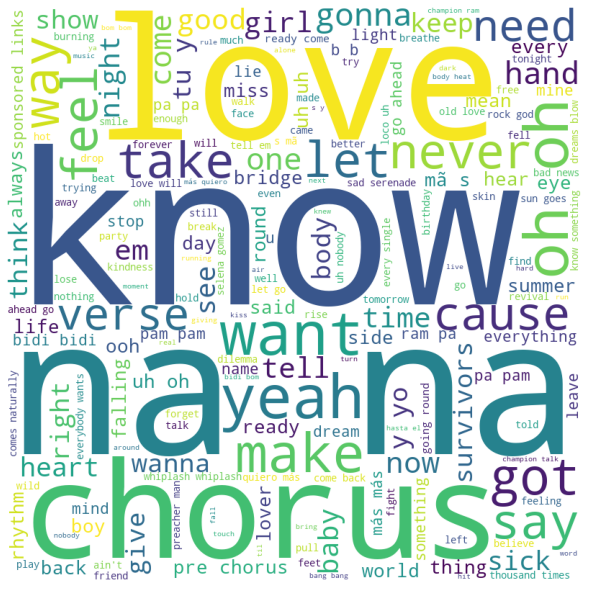

In [14]:
word_plotter(selena_albums_details)

- Justin Bieber Word Cloud

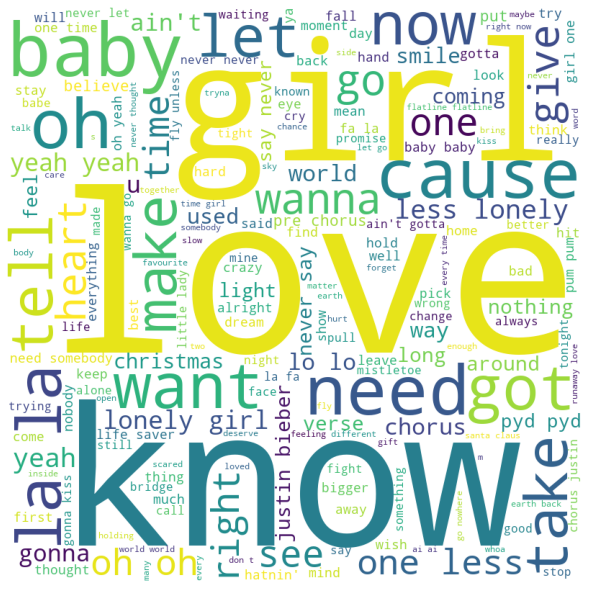

In [15]:
word_plotter(justin_albums_details)

### Merging two Artist Lists

In [16]:
def merge_artists(artist1, artist2):
    merged_list = []
    merged_list.extend(artist1)
    merged_list.extend(artist2)
    return merged_list
    

- Lengths checks

In [17]:
len(selena_list_f), len(justin_list_f)

(101, 157)

- Merge two Lists

In [18]:
merged_list=merge_artists(selena_list_f, justin_list_f)

### Clean the Data

In [19]:
def clean_merged(merged):
    cleaned_lyrics = []
    pattern = r"[^a-zA-Z\s]"
    #pattern = r"[^\w\s]"
    for lyric in merged:
        cleaned_lyric = re.sub(pattern,'',lyric.lower())
        cleaned_lyrics.append(cleaned_lyric)
    return cleaned_lyrics

- Clean Merged List

In [20]:
clean_merged_list=clean_merged(merged_list)

- Create Labels for y (To use in Turning and Model)

In [21]:
labels=["Selena Gomez"]*101+["Justin Bieber"]*157

### 2. Turning text into features

- Vectorizer Function

In [22]:
def apply_vectorizer(song_list):    
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=0.01, ngram_range=(2,3))
    X = vectorizer.fit_transform(song_list)
    X_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out(), index=labels)
    X_df = X_df.reset_index(drop=True)
    return X_df, vectorizer,X

- Apply vectorizer

In [23]:
X_df, vectorizer,X=apply_vectorizer(clean_merged_list)

In [24]:
X_df.head()

,act like,act like dont,adore come,adore come little,afraid cause,afraid cause got,ahead start,ahead start new,aight handle,aight handle hes,...,youre trying,youre tryna,youre world,youre world theres,youre worth,yous gone,yous gone time,yous start,yous start overs,youve got
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X_df.shape

(258, 2471)

In [26]:
def mapping_lists(list, str1, str2):
    mapping=[]
    for i in range(len(list)):
        if(list[i]==str1):
            mapping.append(0)
        else:
            mapping.append(1)
            
    return pd.Series(mapping)

- Mapped (y)

In [27]:
y=mapping_lists(labels, "Selena Gomez", "Justin Bieber")

## Splitting Data and Running model on Train and Test splits

### 1 Logistic

In [28]:
# split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.25, random_state= 42)

# create the model
model= LogisticRegression(max_iter=300)

# fit the model to training data
model.fit(X_train, y_train)
###
# calculate the accuracy score from train data
print("Logistic Model score on the train: %.3f" % model.score(X_train, y_train))

# calculate the accuracy score from test data
print("Logistic Model score on the test: %.3f" % model.score(X_test, y_test))

Logistic Model score on the train: 0.907
Logistic Model score on the test: 0.738


### 2 Random Forest

In [29]:
model2= RandomForestClassifier(n_estimators=1000,max_depth=10)
# fit the pipeline to training data
model2.fit(X_train, y_train)
###
# calculate the accuracy score from train data
print("Random Forest Model score on the train: %.3f" % model2.score(X_train, y_train))

# calculate the accuracy score from test data
print("Random Forest Model score on the test: %.3f" % model2.score(X_test, y_test))

Random Forest Model score on the train: 0.813
Random Forest Model score on the test: 0.738


- Confisuon Matrix on Random Forest

Text(0.5, 1.0, 'Confusion Matrix')

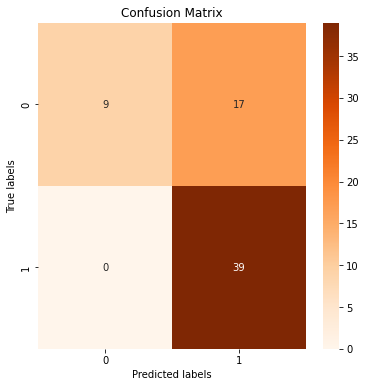

In [30]:
ypred=model2.predict(X_test)
cm=confusion_matrix(y_test,ypred)
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='g', cmap = 'Oranges')
plt.gcf().set_facecolor('white')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

### Cross Validation on Random Forest

- On Train

In [31]:
cv = cross_validate(model2, X = X_train,y = y_train,
                    cv=5,
                    scoring="accuracy",
                    return_train_score=True
                    
)
# convert the dictionary of lists into a DataFrame
cv = pd.DataFrame(cv)
print(cv)

   fit_time  score_time  test_score  train_score
0  1.810998    0.105004    0.666667     0.811688
1  1.547034    0.177966    0.717949     0.857143
2  1.438965    0.103999    0.769231     0.844156
3  1.439034    0.107999    0.710526     0.864516
4  1.381032    0.102984    0.657895     0.851613


### 3 Naive Bayes

In [32]:
# fitting naive bayes to the training set
from sklearn.naive_bayes import MultinomialNB
model_naive = MultinomialNB(alpha = 0.2, fit_prior = True, class_prior = None)
model_naive.fit(X_train, y_train)

# calculate the accuracy score from train data
print("Naive Bayes score on the train: %.3f" % model_naive.score(X_train, y_train))

# calculate the accuracy score from test data
print("Naive Bayes Model score on the test: %.3f" % model_naive.score(X_test, y_test))

Naive Bayes score on the train: 0.974
Naive Bayes Model score on the test: 0.769


### Cross Validation on Naive Bayes

In [33]:
cv = cross_validate(model_naive, X = X_train,y = y_train,
                    cv=5,
                    scoring="accuracy",
                    return_train_score=True
                    
)
# convert the dictionary of lists into a DataFrame
cv = pd.DataFrame(cv)
print(cv)

   fit_time  score_time  test_score  train_score
0  0.032000    0.015999    0.794872     0.980519
1  0.028997    0.024000    0.794872     0.980519
2  0.021997    0.017004    0.717949     0.980519
3  0.027999    0.016999    0.789474     0.980645
4  0.025995    0.022002    0.605263     0.980645


- Confision Matrix on Naive Bayes

Text(0.5, 1.0, 'Confusion Matrix')

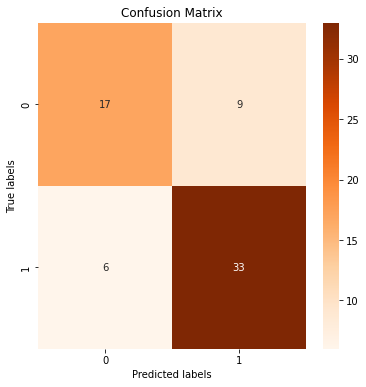

In [34]:
ypred=model_naive.predict(X_test)
cm=confusion_matrix(y_test,ypred)
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='g', cmap = 'Oranges')
plt.gcf().set_facecolor('white')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

### Dump Vektorizer & MODEL

- Dump Vectorizer

In [35]:
import pickle as pic
with open('data/song_vectorizer.pk', 'wb') as fin:
        pic.dump(vectorizer, fin)

- Dump Model

In [36]:
import pickle as pic
with open('data/song_model.pk', 'wb') as fin:
        pic.dump(model_naive, fin)

- Running Dumped Vektorizer & Model

In [37]:
vectorizer_runner=pic.load(open("data/song_vectorizer.pk", "rb"))

In [38]:
model_runner=pic.load(open("data/song_model.pk", "rb"))

### TEST on Vektorizer & MODEL

In [39]:
vectorized=vectorizer_runner.transform(["Don't try to find your spaceship They might be out there waiting"])

In [40]:
model_runner.predict(vectorized)

C:\Users\Master\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [41]:
model_runner.predict_proba(vectorized)[0][1]

0.6113989637305701